<a href="https://colab.research.google.com/github/promckkon/1DCNN/blob/main/MK-DCNN%20with%2010%20NOISE%20in%20CWRU%20Dataset%20251127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [11]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_10_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_OR014_6_1_202.mat


/tmp/ipython-input-2478851265.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['Noise_10_OR014_6_1_202']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_OR007_6_1_136.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_B014_1_190.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_B021_1_227.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190'
 'Noise_10_B021_1_227']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_Time_Normal_1_098.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190'
 'Noise_10_B021_1_227' 'Noise_10_Time_Normal_1_098']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_IR007_1_110.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190'
 'Noise_10_B021_1_227' 'Noise_10_Time_Normal_1_098' 'Noise_10_IR007_1_110']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_OR021

# Multi-Kernel Deep 1D-CNN

In [12]:
pip install tensorflow

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

/tmp/ipython-input-701766332.py:32: UserWarning: The palette list has more values (14) than needed (9), which may not be intended.
  sns.scatterplot(


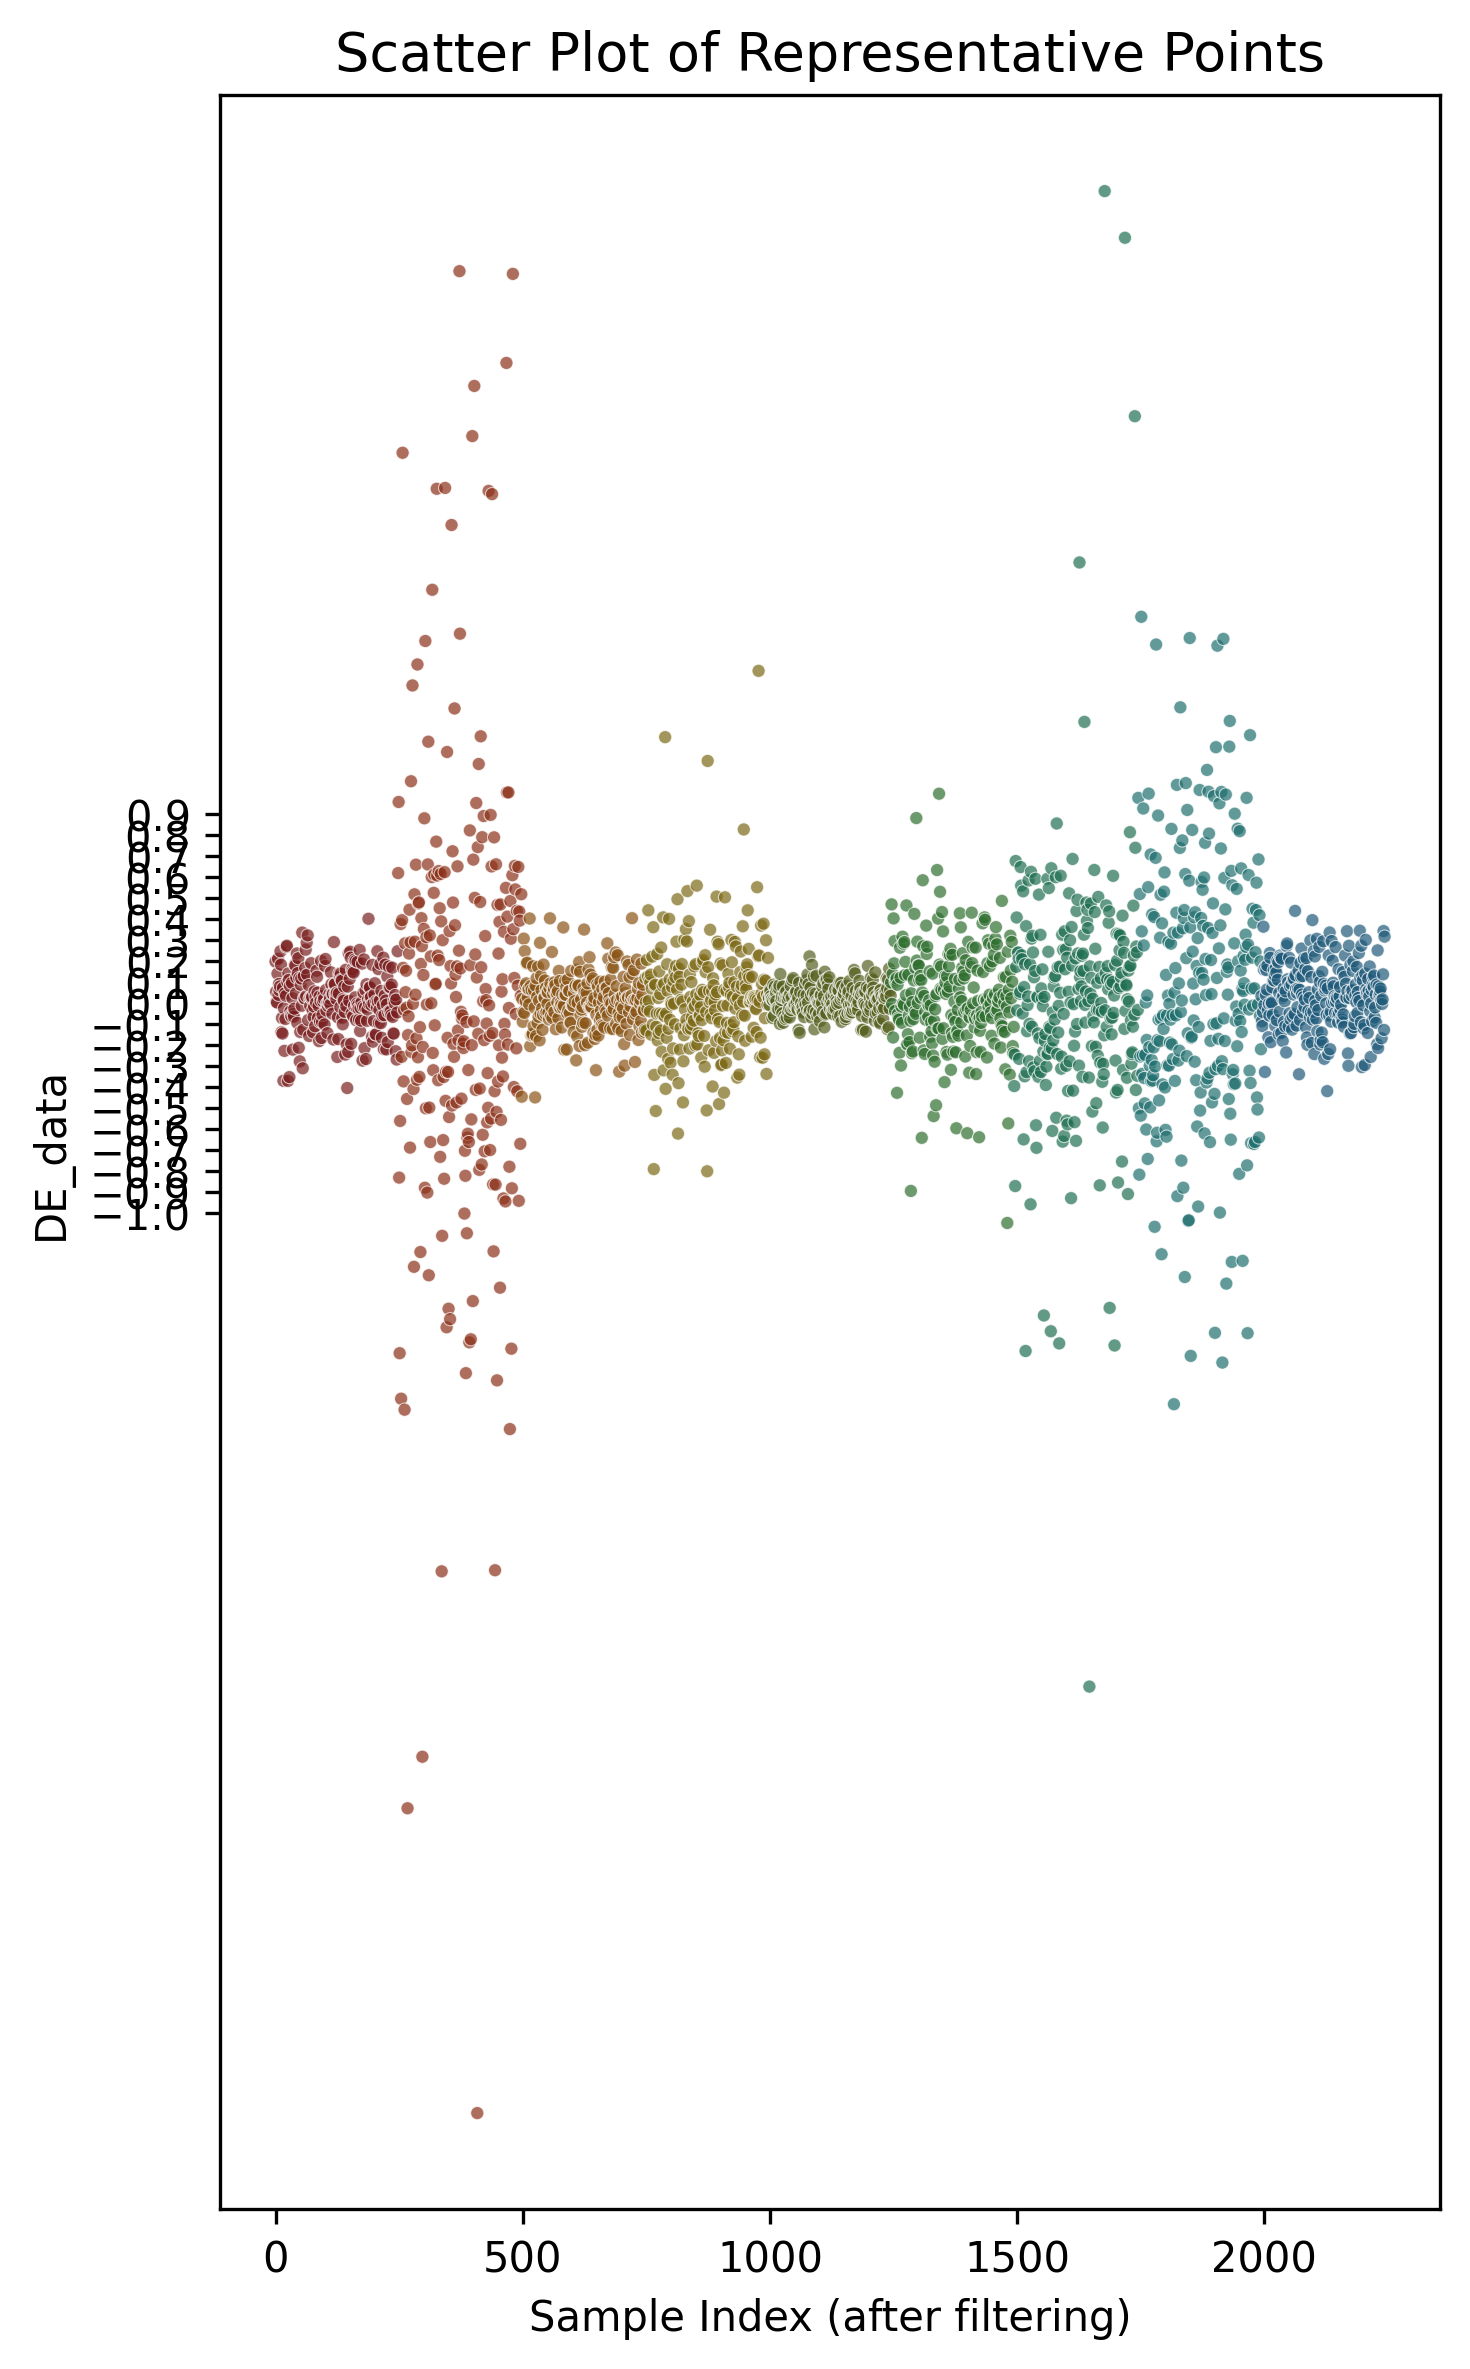

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 顏色（延續你之前的 palette）
palette = [
    "#7A1F1F", "#8C311A", "#8A5516", "#7D6A17",
    "#56601F", "#2F6F2F", "#1F6F52", "#1F6F6F",
    "#1F5A7A", "#1F3F8A", "#352F8A", "#5A2F8A",
    "#7A2F8A", "#8A2F6F"
]

# 取每個 window 的「代表值」（第一個點）
wave_point = X[:, 0, 0]

# 取 label 做顏色編碼
fault_label = Y[:]

# ❗ 過濾掉離群值（避免太遠的 y 顯示出來）
# 例如把 |y| > 6 的點去除（你可以自己調整）
threshold = 6
mask = np.abs(wave_point) <= threshold

wave_point = wave_point[mask]
fault_label = fault_label[mask]

# X 軸 index
x_idx = np.arange(len(wave_point))

plt.figure(figsize=(5, 8), dpi=300)

sns.scatterplot(
    x=x_idx,
    y=wave_point,
    hue=fault_label,
    palette=palette,
    s=10,
    alpha=0.7,
    legend=False
)

plt.yticks(np.arange(-1, 1,0.1))  # 由 -6 到 6，間隔 0.5，你可以調整

plt.xlabel("Sample Index (after filtering)")
plt.ylabel("DE_data")
plt.title("Scatter Plot of Representative Points", fontsize=13)

plt.tight_layout()
plt.savefig("pre_600dpi.png", dpi=600, bbox_inches="tight")

plt.show()

# 下載圖檔
from google.colab import files
files.download("pre_600dpi.png")


Statistical Features

In [15]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2431, STRIDE: 1944
Extracted 2244 rows (target: 1800)
                       fault  window      mean       std       rms       max  \
0     Noise_10_OR014_6_1_202       1  0.015249  0.146771  0.147561  0.594737   
1     Noise_10_OR014_6_1_202       2  0.013508  0.146190  0.146813  0.594737   
2     Noise_10_OR014_6_1_202       3  0.014151  0.150835  0.151498  0.498249   
3     Noise_10_OR014_6_1_202       4  0.012434  0.152739  0.153244  0.559526   
4     Noise_10_OR014_6_1_202       5  0.009703  0.141148  0.141482  0.516066   
...                      ...     ...       ...       ...       ...       ...   
2239     Noise_10_B007_1_123     246  0.016597  0.149658  0.150575  0.593600   
2240     Noise_10_B007_1_123     247  0.015316  0.173308  0.173983  0.622776   
2241     Noise_10_B007_1_123     248  0.015049  0.151986  0.152729  0.479625   
2242     Noise_10_B007_1_123     249  0.017314  0.153895  0.154866  0.650435   
2243     Noise_10_B007_1_123     250  0.01

/tmp/ipython-input-169089458.py:24: UserWarning: The palette list has more values (14) than needed (9), which may not be intended.
  sns.scatterplot(
/tmp/ipython-input-169089458.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


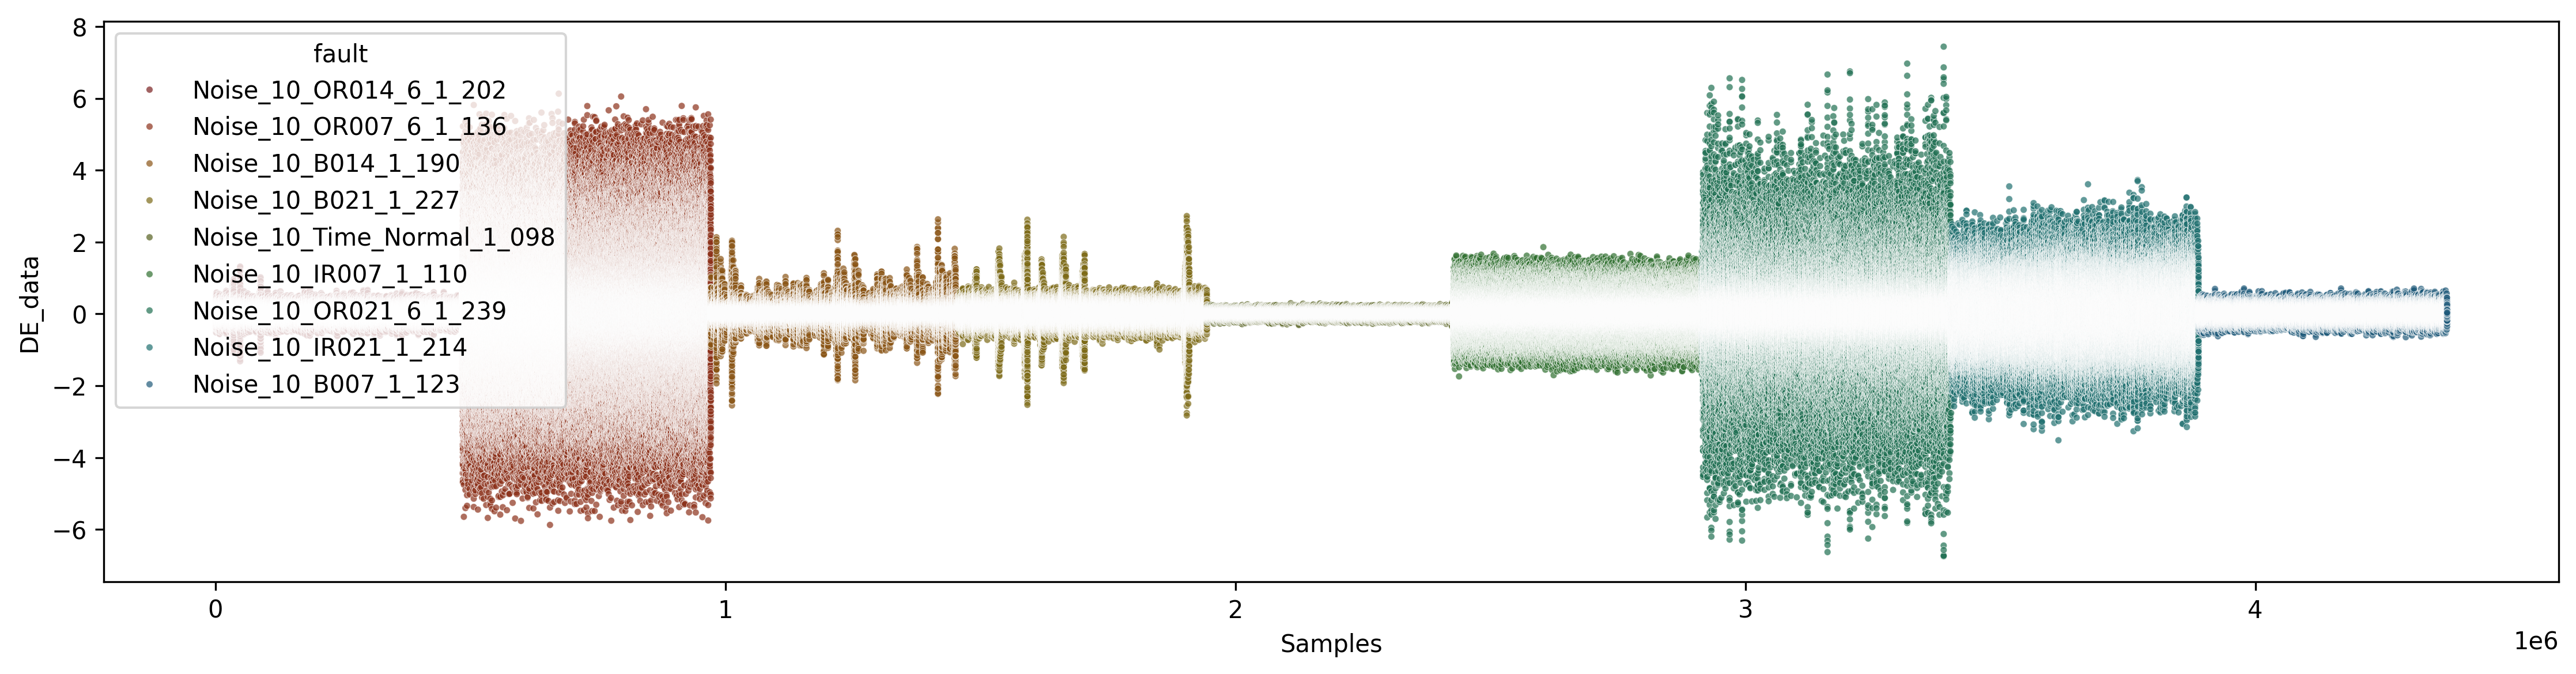

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 你的彩虹色票
palette = [
    "#7A1F1F", "#8C311A", "#8A5516", "#7D6A17",
    "#56601F", "#2F6F2F", "#1F6F52", "#1F6F6F",
    "#1F5A7A", "#1F3F8A", "#352F8A", "#5A2F8A",
    "#7A2F8A", "#8A2F6F"
]

# wave_df = 原始訊號的 DataFrame（如果不是 df，就改名字）
wave_df = df

# 第一欄當作波形
wave_col = wave_df.columns[0]

# x 軸 = 所有樣本索引
x_index = np.arange(len(wave_df))

plt.figure(figsize=(15, 4), dpi=300)

sns.scatterplot(
    data=wave_df,
    x=x_index,
    y=wave_col,
    hue="fault",
    palette=palette,
    s=8,          # 點的大小，可以再調
    alpha=0.7,

)

plt.xlabel("Samples")
plt.ylabel(wave_col)
plt.tight_layout()
plt.show()
